# Evaluate the performance of various models

Please email at sd3596@columbia.edu to get the pretrained models 

In [1]:
import sys
import os
import random
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.bgm import *
from models.sagan import *
from models.causal_model import *
from load_data import *

In [2]:
root_folder = 'dataset/celebA/'
img_dim = 64
batch_size = 128
causal_diagram = 'smiling'

saved_folder = 'saved_model/entiredata'
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']
num_label = len(cols)
A = torch.zeros((num_label, num_label))
A[0, 2:6] = 1
A[1, 4] = 1
    
test_dataloader = get_dataloader(root_folder,'dear_test', img_dim=img_dim, 
                                 batch_size=batch_size, cols = cols, shuffle=False)    

In [3]:
in_channels = 3
fc_size = 2048

latent_dim = 100

g_conv_dim = 32
enc_dist='gaussian'
enc_arch='resnet'
enc_fc_size=2048
enc_noise_dim=128
dec_dist = 'implicit'
prior = 'linscm'

In [4]:
model = BGM(latent_dim, g_conv_dim, img_dim,
                enc_dist, enc_arch, enc_fc_size, enc_noise_dim, dec_dist,
                prior, num_label, A)
model = nn.DataParallel(model)

In [5]:
checkpoint = torch.load(f'{saved_folder}/bgm', map_location='cpu')
print(checkpoint['epoch'])

130


In [6]:
model.load_state_dict(checkpoint['model_state_dict'])
model = model.module.to('cpu')

In [7]:
def plot_image(fake, c=10, r=None, ):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
        r = 1 if r is None else r
        _,ax = plt.subplots(r, c, figsize=(24,3*r))
        if r == 1:
            for i in range(10):
                ax[i].imshow(fake[i])
                ax[i].set_xticks([])
                ax[i].set_yticks([])
        else:
            for i in range(r):
                ax[i][0].set_ylabel(cols[i])
                for j in range(c):
                    ax[i][j].imshow(fake[i*c+j])
                    ax[i][j].set_xticks([])
                    ax[i][j].set_yticks([])
                    
        plt.show()

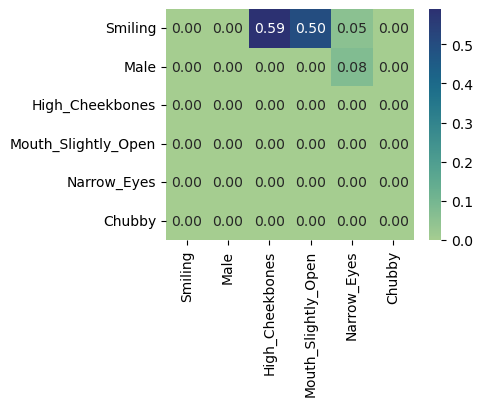

In [30]:
arr = model.prior.A.detach().numpy()
heat = pd.DataFrame(arr, columns=cols)
plt.figure(figsize=(4,3))
sns.heatmap(heat, annot=True, cmap="crest",yticklabels=cols, fmt='.2f')
plt.show()

Reconstruct


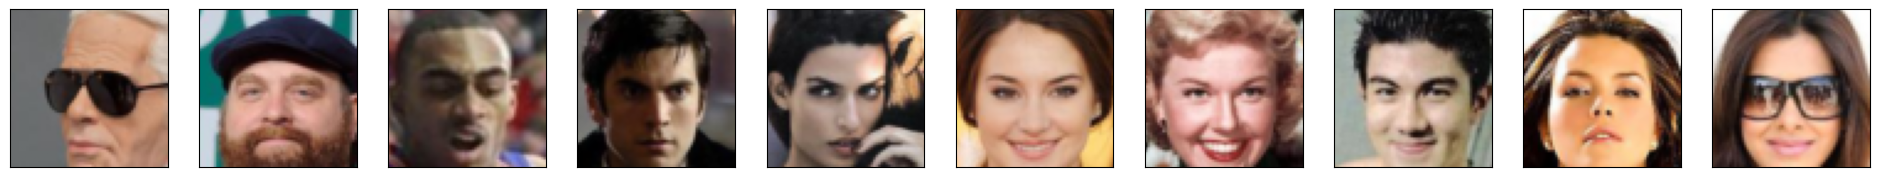

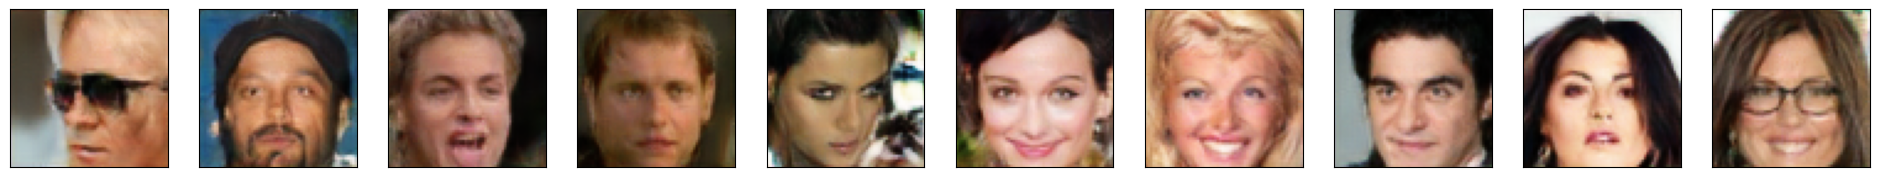

tensor([[-1.0780e+02,  2.5536e+00,  2.0237e+01, -1.1321e+02, -9.9704e+01,
          1.3712e+01],
        [-1.2106e+02,  2.9021e+02, -8.6392e+01, -5.0491e+01, -4.9701e+01,
         -2.0319e-01],
        [-6.2931e+01,  2.0413e+02, -1.4259e+01,  4.7318e+01,  1.9497e+01,
         -5.3969e+01],
        [-5.0372e+01,  1.3705e+02, -3.3870e+01, -5.2392e+01, -5.5669e+01,
         -6.8995e+01],
        [-1.8624e+02, -1.8724e+02, -2.0470e+02, -1.5319e+02, -7.6597e+01,
         -5.4136e+01],
        [ 1.4909e+02, -1.8128e+02,  3.6834e+01,  9.4271e+01, -4.2598e+01,
         -9.5072e+01],
        [ 3.4098e+02, -3.1695e+02,  1.3320e+02,  2.4404e+02, -4.2993e+00,
         -3.9937e+01],
        [ 4.4283e+01,  1.5684e+02,  4.9350e+01, -3.3817e+01, -7.6649e+01,
         -2.2144e+01],
        [-1.4507e+02, -4.1181e+02, -3.4461e+01, -5.9672e+01,  4.2952e+00,
         -1.3155e+02],
        [ 1.3649e+02, -7.4280e+01,  8.7876e+01,  4.6321e+01, -5.1151e+01,
         -5.8470e+01]])
tensor([[0., 1., 0., 0., 0., 

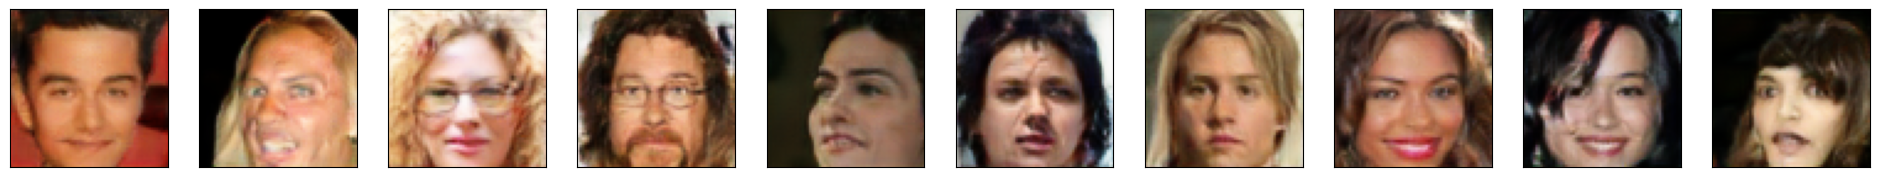

In [9]:
t = 10
for batch_idx, (x, label) in enumerate(test_dataloader):
    with torch.no_grad():
        x = x.to('cpu')
        x_ = x[:t]
        x_recon = model(x_, recon=True)
        x_recon = (x_recon * 0.5) + 0.5
        print('Reconstruct')
        plot_image(x_*0.5 + 0.5)
        plot_image(x_recon)
        feat = model.prior(model(x)[:t, :num_label])
        print(model.prior(model.encode(x_)[:t, :][:,:num_label]))
        print(label[:t, :])
        print(torch.round(torch.sigmoid(feat)))
        
        print('Random')
        z = torch.randn(x.size(0), latent_dim, device=x.device)
        x_fake = model(None, z)
        x_fake = x_fake * 0.5 + 0.5
        plot_image(x_fake)
        
    break

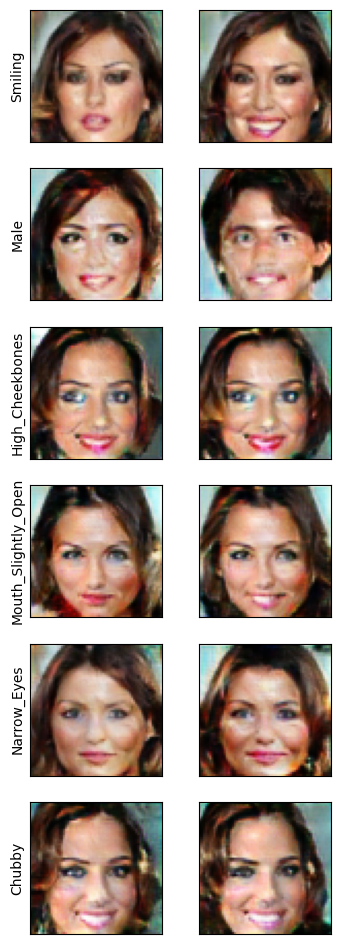

In [10]:
_, ax = plt.subplots(num_label,2, figsize=(4,12))
with torch.no_grad():
    for col_num in range(num_label):
        ax[col_num][0].set_ylabel(cols[col_num])
        eps = torch.randn(1, latent_dim, device='cpu')
        eps[:, :num_label] = torch.zeros(1, num_label, device='cpu')
        for i in range(2):   
            label_z = model.prior(eps[:, :num_label])
            orig_z = label_z.detach()
            label_z[:, 1] = -25
            label_z[:, col_num] = -10 if i==0 else 10
            #label_z = model.prior.intervene(label_z, orig_z)
            other_z = eps[:, num_label:]
            z = torch.cat([label_z, other_z], dim=1)
            temp = model.decoder(z)
            
            temp = np.transpose(temp.numpy(), (0, 2, 3, 1))[0]
            temp = temp*0.5 + 0.5
            ax[col_num][i].imshow(temp)
            ax[col_num][i].set_xticks([])
            ax[col_num][i].set_yticks([])

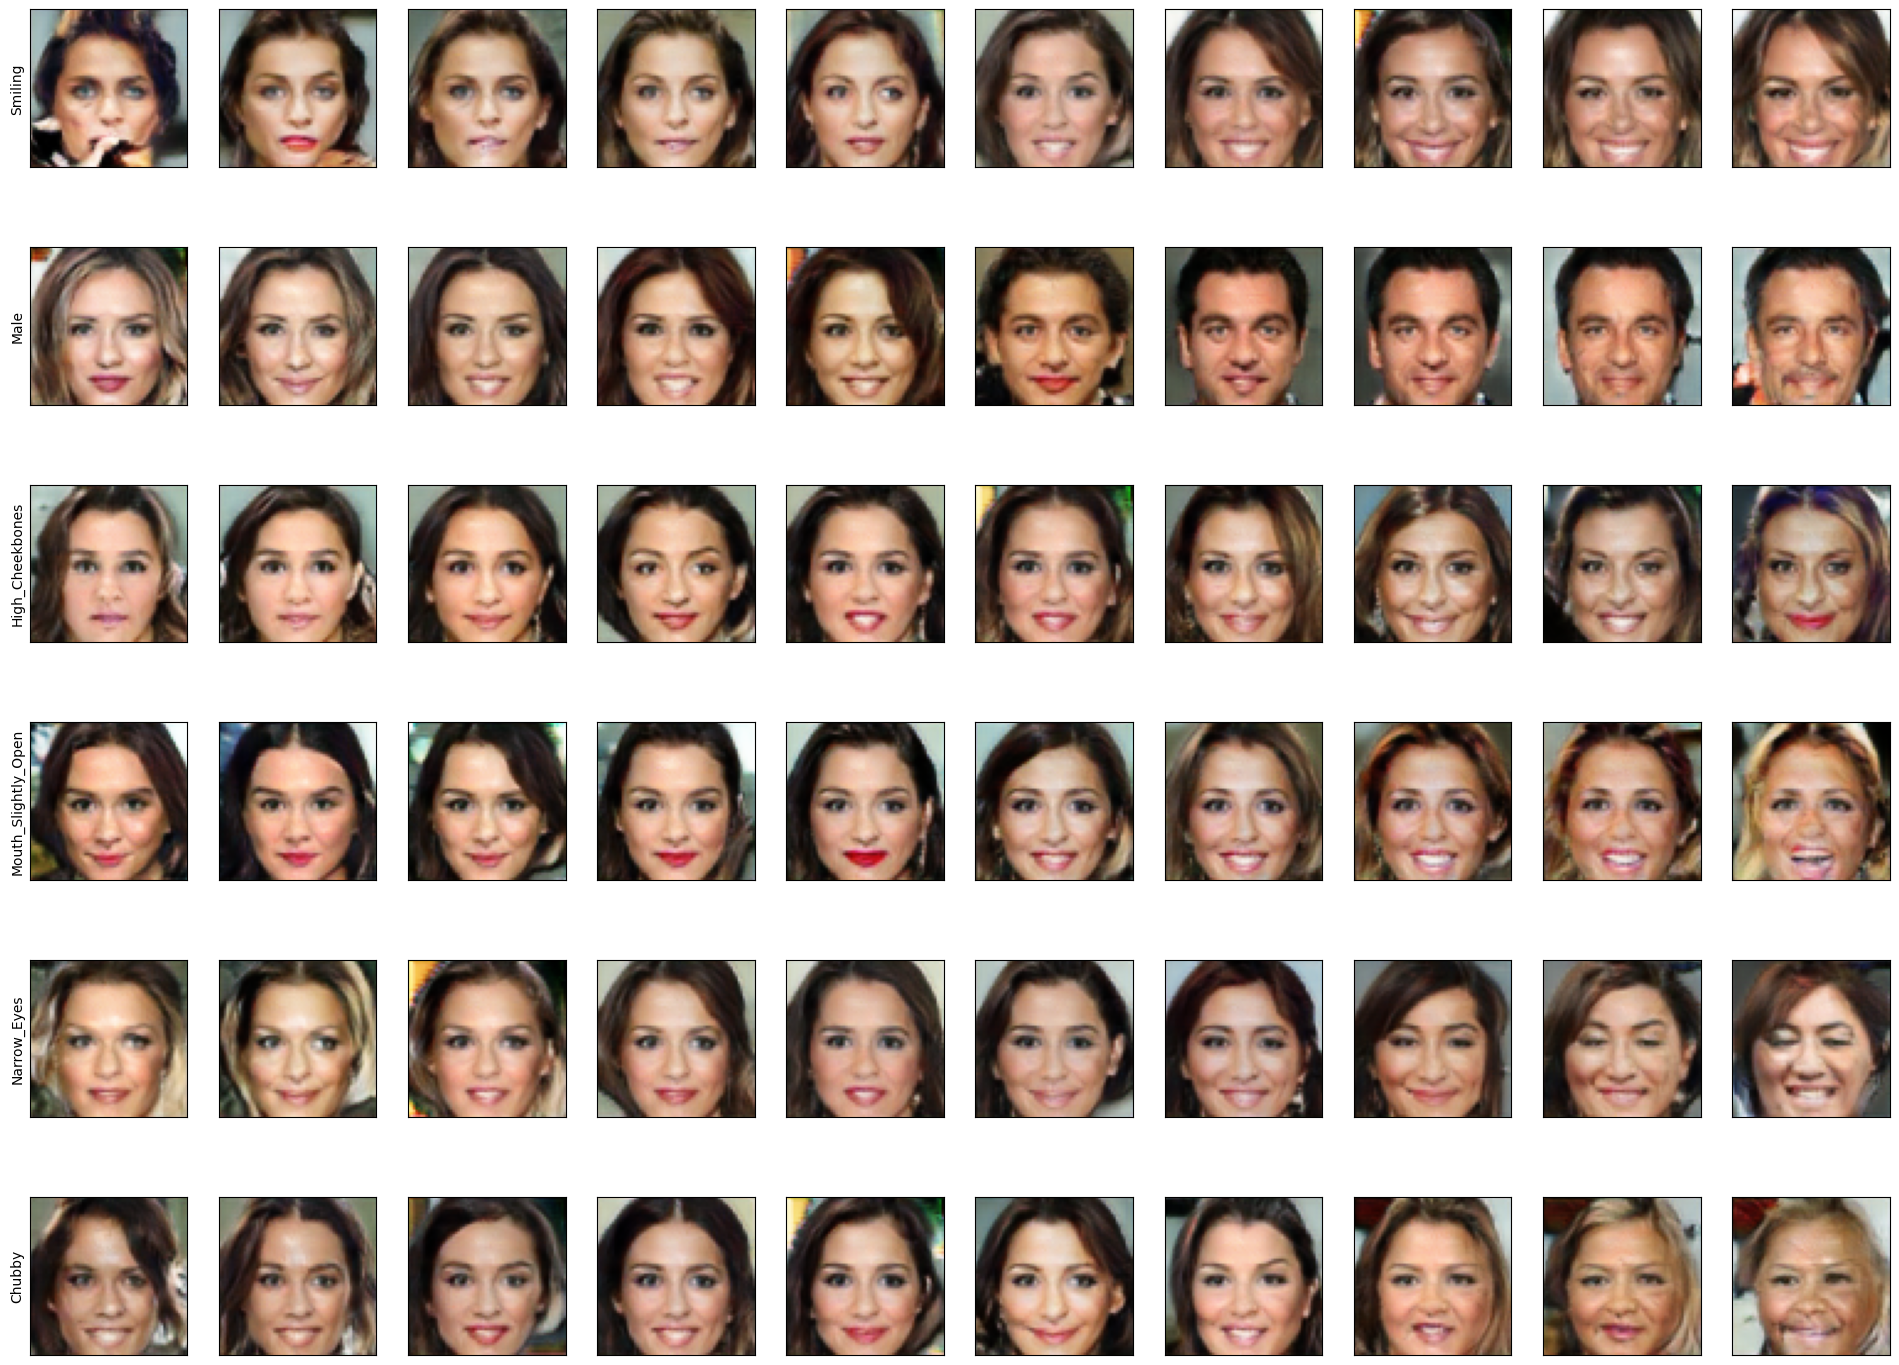

In [36]:
fixed_zeros = torch.zeros(1, latent_dim, device='cpu')
temp = model.traverse(fixed_zeros)
temp = temp * 0.5 + 0.5
plot_image(temp, r = num_label, c = 10)